## 1. Imports & Setup


In [2]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


## 2. Load Dataset


In [6]:
DATA_PATH = os.path.join("data", "AmesHousing.csv")
TARGET_COL = "SalePrice"

df = pd.read_csv(DATA_PATH)
df.shape

(2930, 82)

## 3. Exploratory Data Analysis (EDA)

EDA helps us:
- Understand data distribution
- Identify missing values
- Observe relationships between features and house price


In [7]:
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

### 3.1 Missing Values Analysis


In [9]:
missing = df.isnull().sum().sort_values(ascending=False)
missing[missing > 0].head(10)

Pool QC          2917
Misc Feature     2824
Alley            2732
Fence            2358
Mas Vnr Type     1775
Fireplace Qu     1422
Lot Frontage      490
Garage Cond       159
Garage Finish     159
Garage Yr Blt     159
dtype: int64

### 3.2 Target Variable Distribution

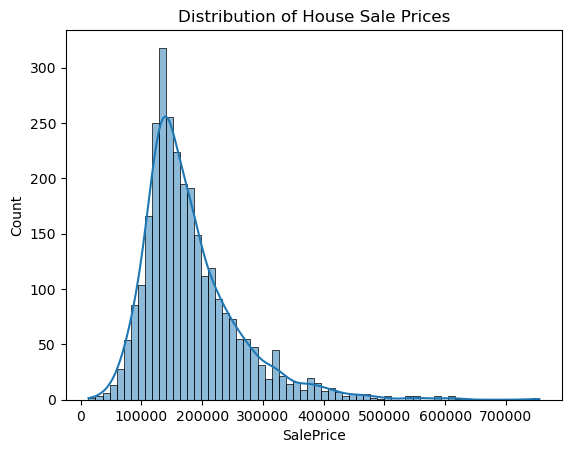

In [10]:
plt.figure()
sns.histplot(df[TARGET_COL], kde=True)
plt.title("Distribution of House Sale Prices")
plt.show()


### 3.3 Correlation with SalePrice (Top Numeric Features)


In [11]:
numeric_df = df.select_dtypes(include=np.number)
corr = numeric_df.corr()[TARGET_COL].sort_values(ascending=False)

corr.head(10)


SalePrice         1.000000
Overall Qual      0.799262
Gr Liv Area       0.706780
Garage Cars       0.647877
Garage Area       0.640401
Total Bsmt SF     0.632280
1st Flr SF        0.621676
Year Built        0.558426
Full Bath         0.545604
Year Remod/Add    0.532974
Name: SalePrice, dtype: float64

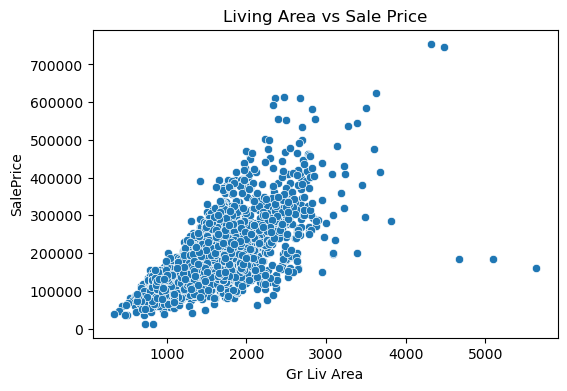

In [12]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=df["Gr Liv Area"], y=df[TARGET_COL])
plt.title("Living Area vs Sale Price")
plt.show()


## 4. Feature Selection & Train-Test Split


In [13]:
df = df.dropna(subset=[TARGET_COL])

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


## 5. Preprocessing Pipeline


In [14]:
numeric_features = X_train.select_dtypes(include=np.number).columns
categorical_features = X_train.select_dtypes(exclude=np.number).columns

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])


## 6. Train Individual Models
We train **three regression algorithms**:
1. Linear Regression  
2. Random Forest Regressor  
3. Gradient Boosting Regressor  


In [15]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

pipelines = {}

for name, model in models.items():
    pipelines[name] = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", model)
    ])
    pipelines[name].fit(X_train, y_train)

print("All base models trained.")


All base models trained.


## 7. Evaluation Function


In [16]:
def evaluate(model, X_test, y_test):
    preds = model.predict(X_test)
    return {
        "MAE": mean_absolute_error(y_test, preds),
        "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
        "R2": r2_score(y_test, preds)
    }


In [17]:
results = []

for name, pipe in pipelines.items():
    metrics = evaluate(pipe, X_test, y_test)
    results.append({"Model": name, **metrics})

results_df = pd.DataFrame(results)
results_df


,Model,MAE,RMSE,R2
0,Linear Regression,16034.118776,29635.431215,0.890458
1,Random Forest,15834.860222,26706.194812,0.911043
2,Gradient Boosting,15279.347134,26359.301741,0.913338


## 8. Voting Regressor (Ensemble Model)

The Voting Regressor combines predictions from multiple models to improve accuracy.


In [18]:
voting_regressor = VotingRegressor(
    estimators=[
        ("lr", pipelines["Linear Regression"]),
        ("rf", pipelines["Random Forest"]),
        ("gb", pipelines["Gradient Boosting"])
    ]
)

voting_regressor.fit(X_train, y_train)


VotingRegressor(estimators=[('lr',
                             Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['Order', 'PID', 'MS SubClass', 'Lot Frontage', 'Lot Area',
       'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add',
       'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bs...
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', 'Kitchen Qual', 'Functional',
       'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual',
       'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence', 'Misc Feature',
       'Sale Type', 'Sale Condition'],
      dtype='object'))])),
                                             ('model',
                                              GradientBoostingRegressor(random_state=42))]))])

In [19]:
voting_metrics = evaluate(voting_regressor, X_test, y_test)
results_df = pd.concat([
    results_df,
    pd.DataFrame([{"Model": "Voting Regressor", **voting_metrics}])
])

results_df.sort_values("RMSE")


,Model,MAE,RMSE,R2
0,Voting Regressor,13787.927284,25338.057976,0.919923
2,Gradient Boosting,15279.347134,26359.301741,0.913338
1,Random Forest,15834.860222,26706.194812,0.911043
0,Linear Regression,16034.118776,29635.431215,0.890458


## 9. Save Best Model


In [20]:
best_model_name = results_df.sort_values("RMSE").iloc[0]["Model"]

best_model = (
    voting_regressor if best_model_name == "Voting Regressor"
    else pipelines[best_model_name]
)

os.makedirs("artifacts", exist_ok=True)
joblib.dump(best_model, "artifacts/pipeline.joblib")
results_df.to_csv("artifacts/metrics.csv", index=False)

best_model_name


'Voting Regressor'

## 11. Model Performance Comparison (Visualization)

The following bar charts compare all trained models using standard regression metrics:
- RMSE (lower is better)
- MAE (lower is better)
- R² score (higher is better)
